# Project: Machine Learning for Texts

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy

# Download nltk resources
nltk.download('stopwords')
nltk.download('punkt')

# Load spacy language model for text processing
nlp = spacy.load('en_core_web_sm')

# Set plot style for visualizations
sns.set(style="whitegrid")


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

## Load Data

In [3]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [4]:
# Load the IMDb movie review dataset
data = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t')

# Inspect the data
data.head()


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## EDA

Let's check the number of movies and reviews over years.

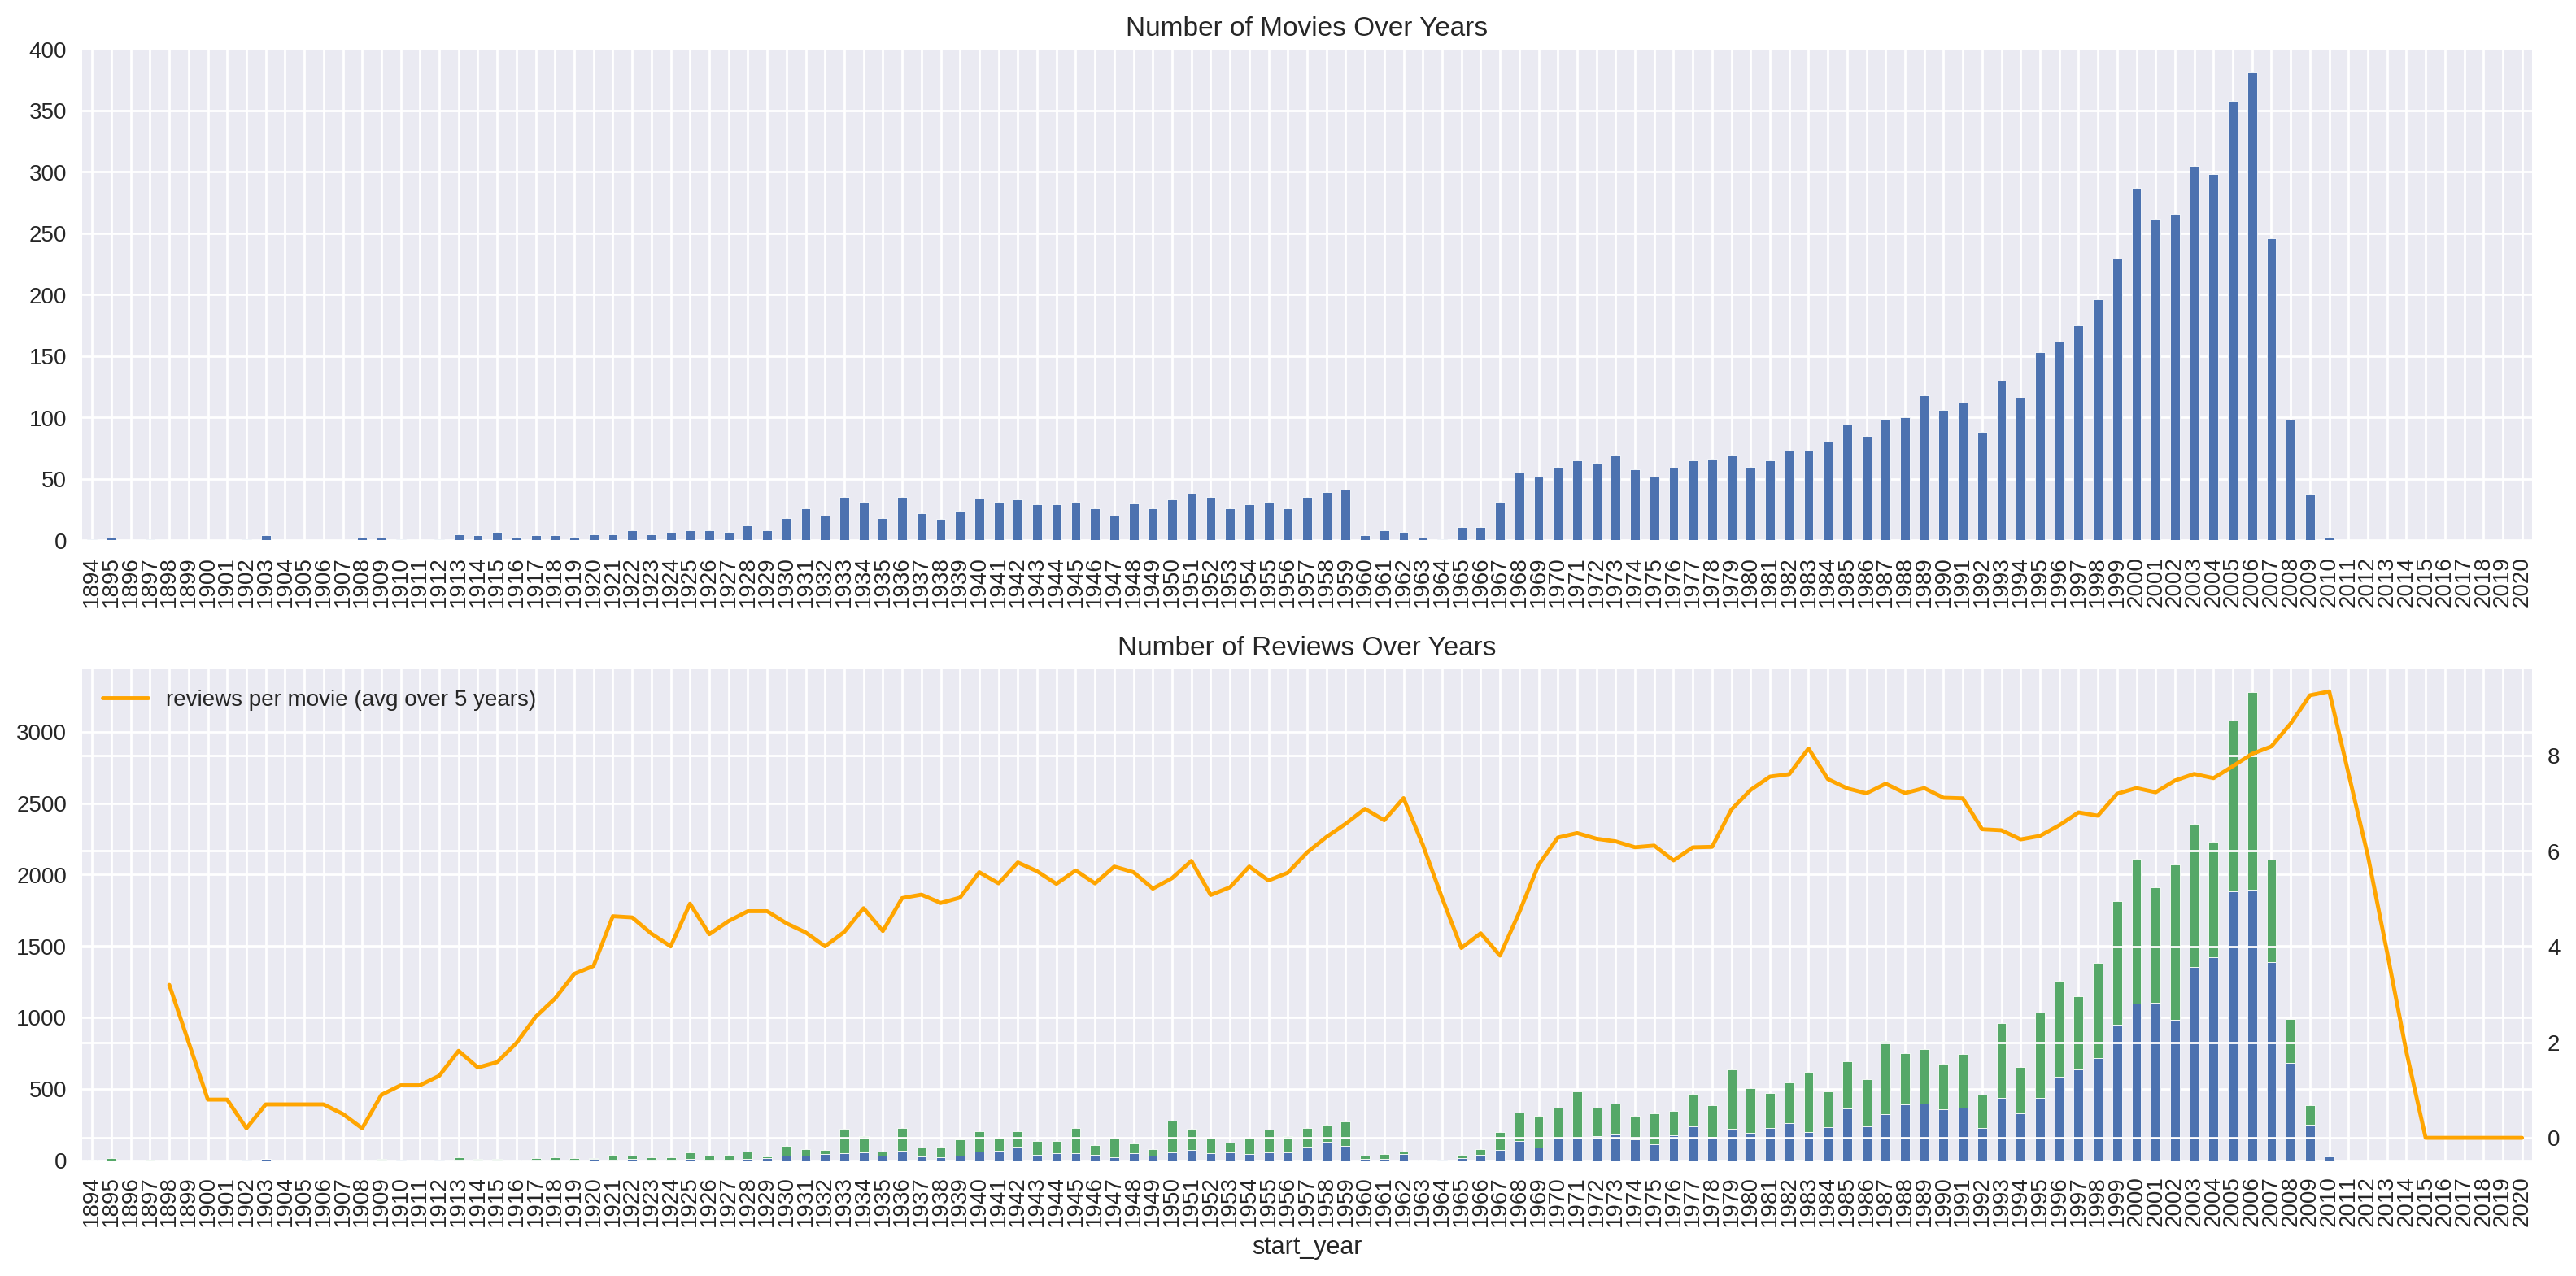

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Conclusions: 

The charts show a consistent increase in the number of movies produced over time, peaking around 2020. This growth correlates with a rise in movie reviews as well. The second chart reveals that while the number of reviews (both positive and negative) generally increased over the years, the ratio of reviews per movie has fluctuated. The rolling average (orange line) highlights a significant increase in reviews per movie in more recent years, potentially indicating the growing popularity of movie reviews and user engagement on platforms like IMDb

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

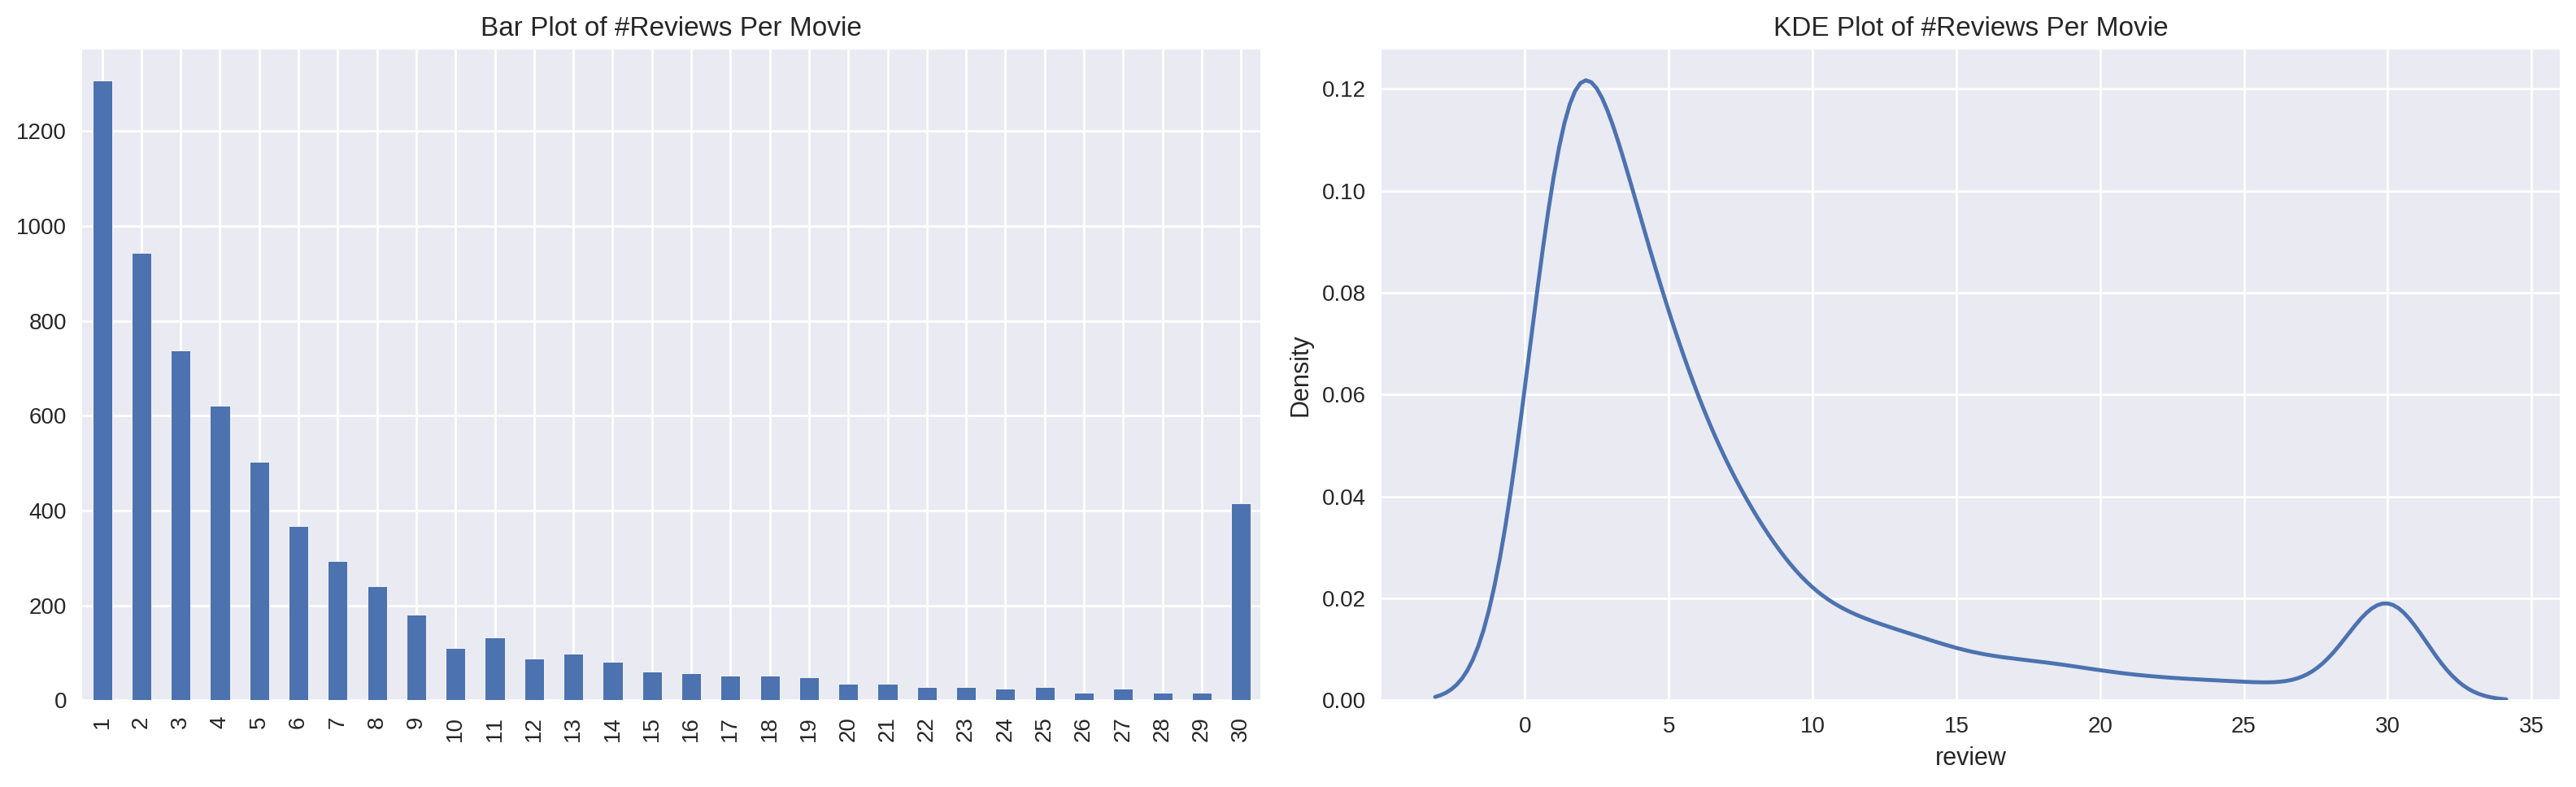

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Conclusions: 

The bar plot shows that a large number of movies receive only a handful of reviews, with a peak at movies having a small number of reviews, typically around 1 to 10 reviews. This may be due to the fact that most movies, especially lesser-known ones, do not attract much attention or a broad audience.

On the other hand, some blockbuster movies or widely discussed films accumulate a disproportionately large number of reviews, which is reflected in the long tail seen in the KDE plot. These films might have larger fan bases, generate more controversy, or simply have more visibility, leading to a higher volume of reviews.

This distribution is common on user-generated platforms where a small number of items receive the majority of attention, while the majority remain less noticed.

In [7]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

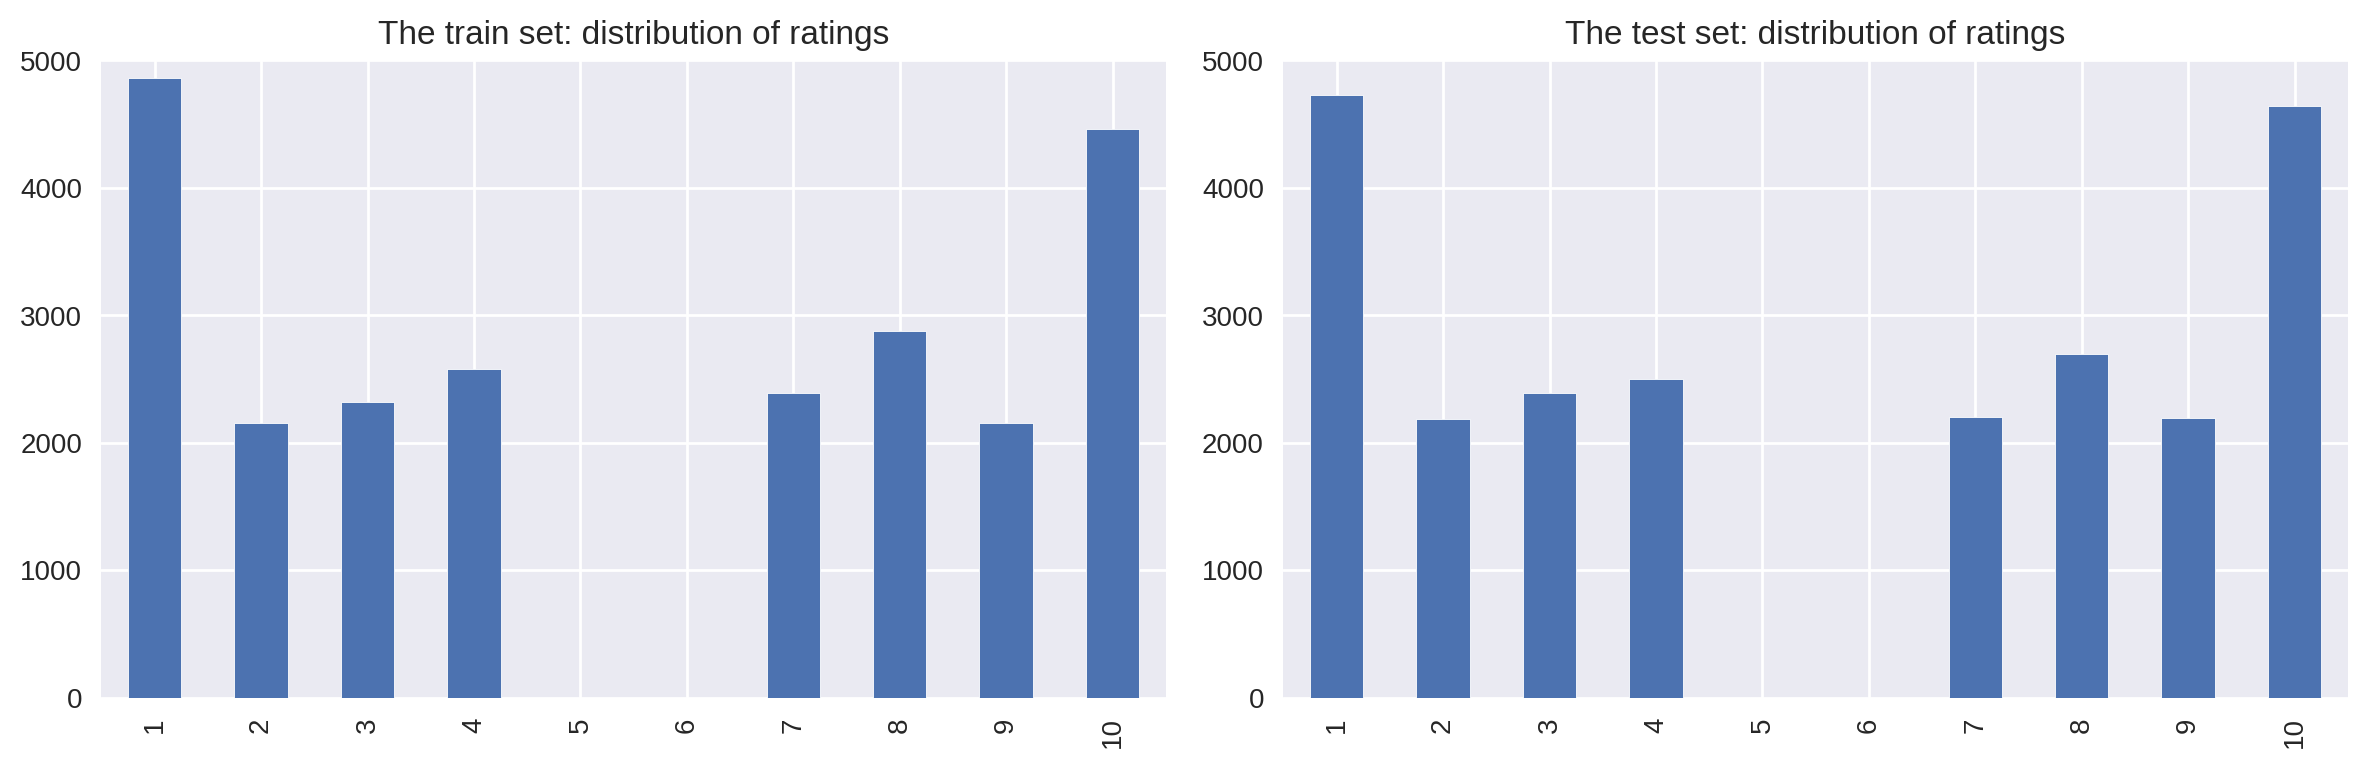

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Conclusions:

Both the training and test sets exhibit a similar distribution of ratings. The ratings appear to be reasonably balanced across different values, though certain ratings, particularly around the middle range (4 to 7), seem to occur more frequently. This could indicate that most users tend to rate movies in this average range rather than giving extreme ratings (either very low or very high). Additionally, the consistency of the distribution across both sets suggests that the data is split appropriately, ensuring that the model will not encounter drastically different rating patterns between the training and test sets.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


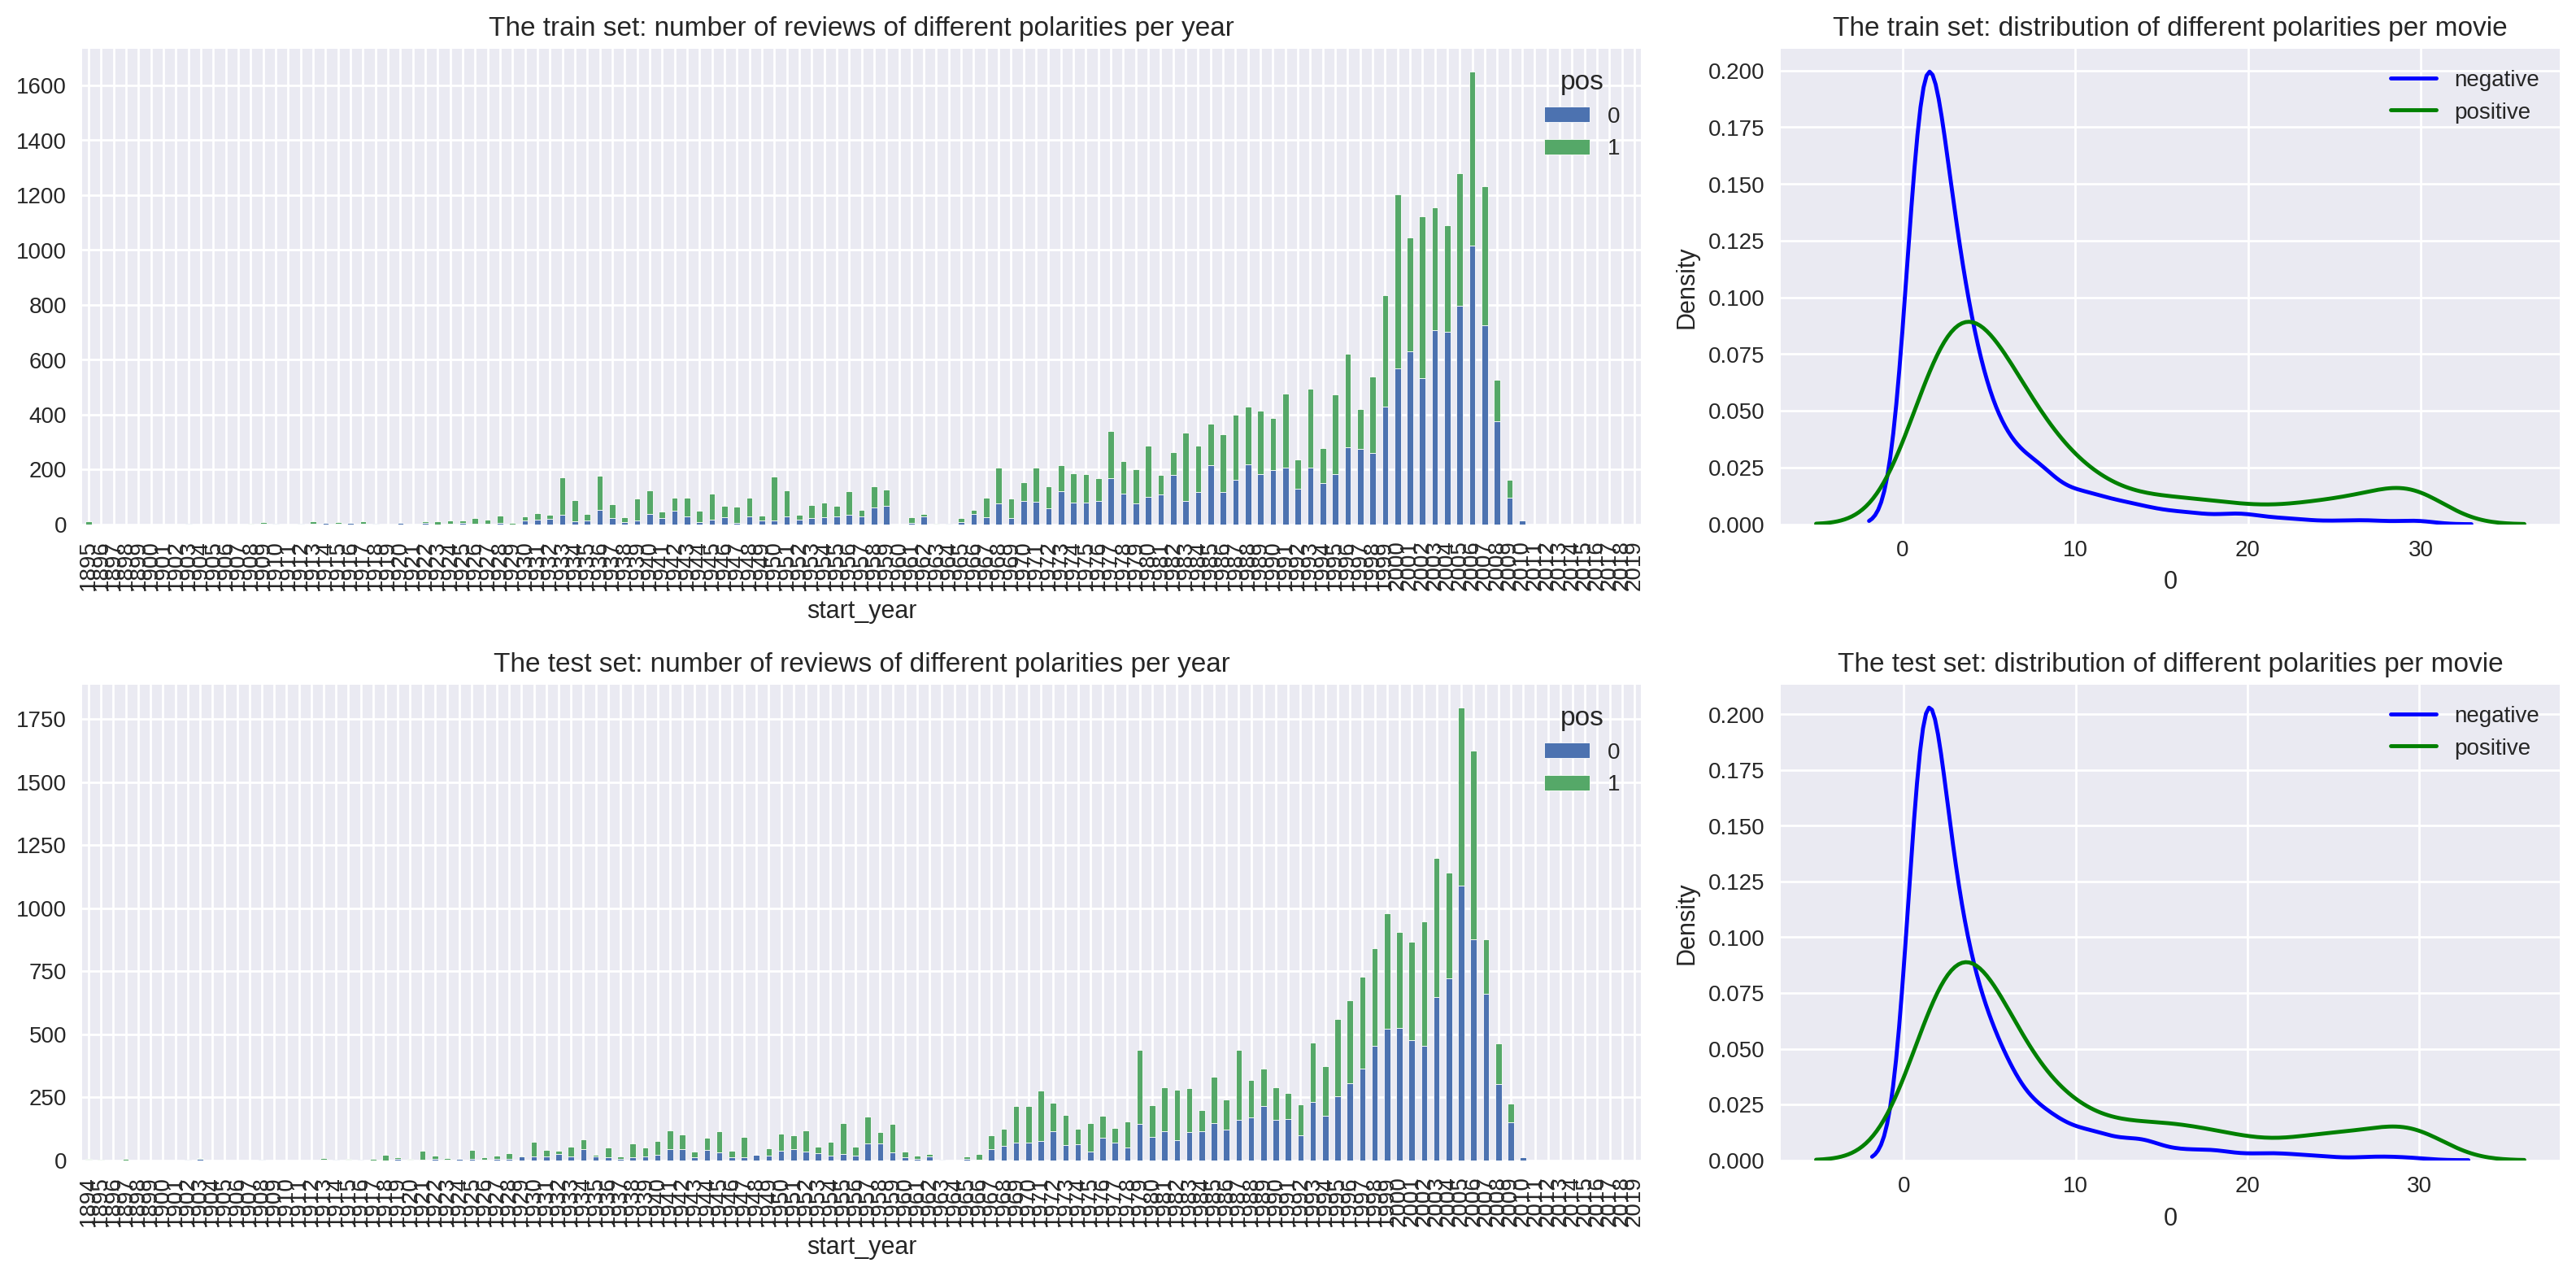

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Conclusions:

The bar charts show that over the years, both positive and negative reviews follow a similar pattern in both the training and test sets, with a noticeable increase in the number of reviews in recent years. This likely reflects the growing popularity of online movie reviews in general.

In terms of per-movie distributions, the KDE plots highlight a similar trend in both the train and test sets: movies tend to attract more positive reviews than negative ones, though a subset of films receives a higher proportion of negative feedback. This balanced representation of both positive and negative reviews across the dataset indicates that the model will have sufficient data for effective training and testing in both polarities.

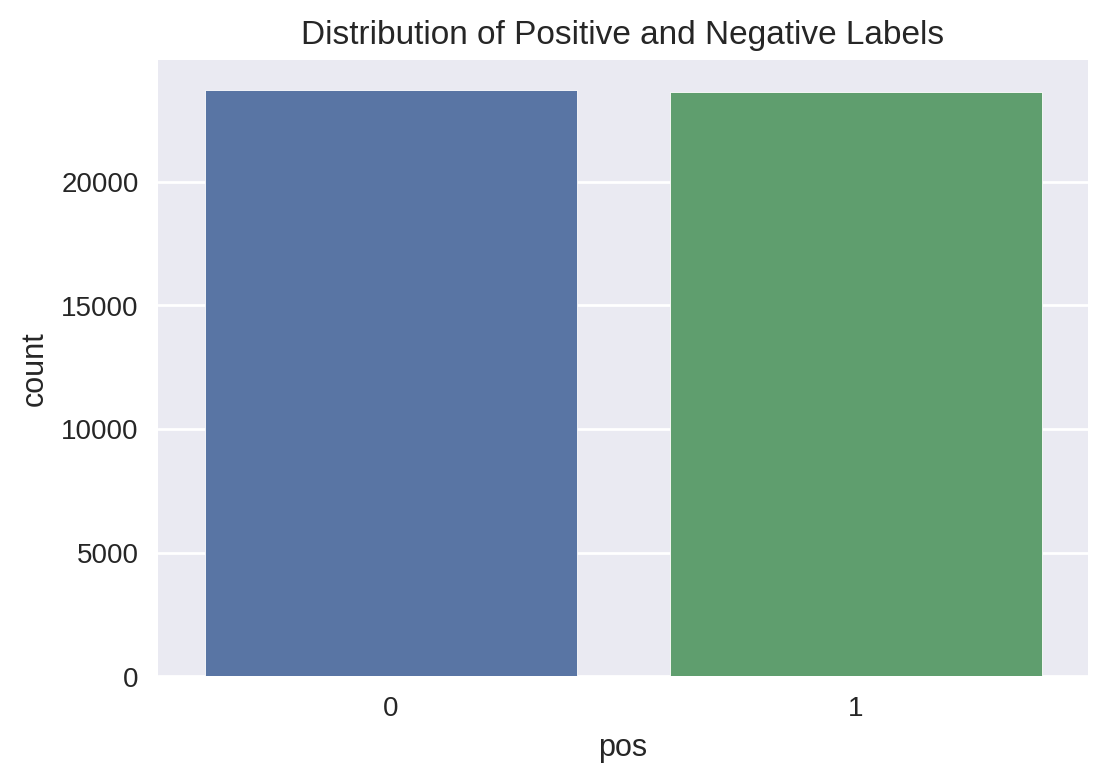

Total number of reviews: 47331
Number of positive reviews: 23616
Number of negative reviews: 23715


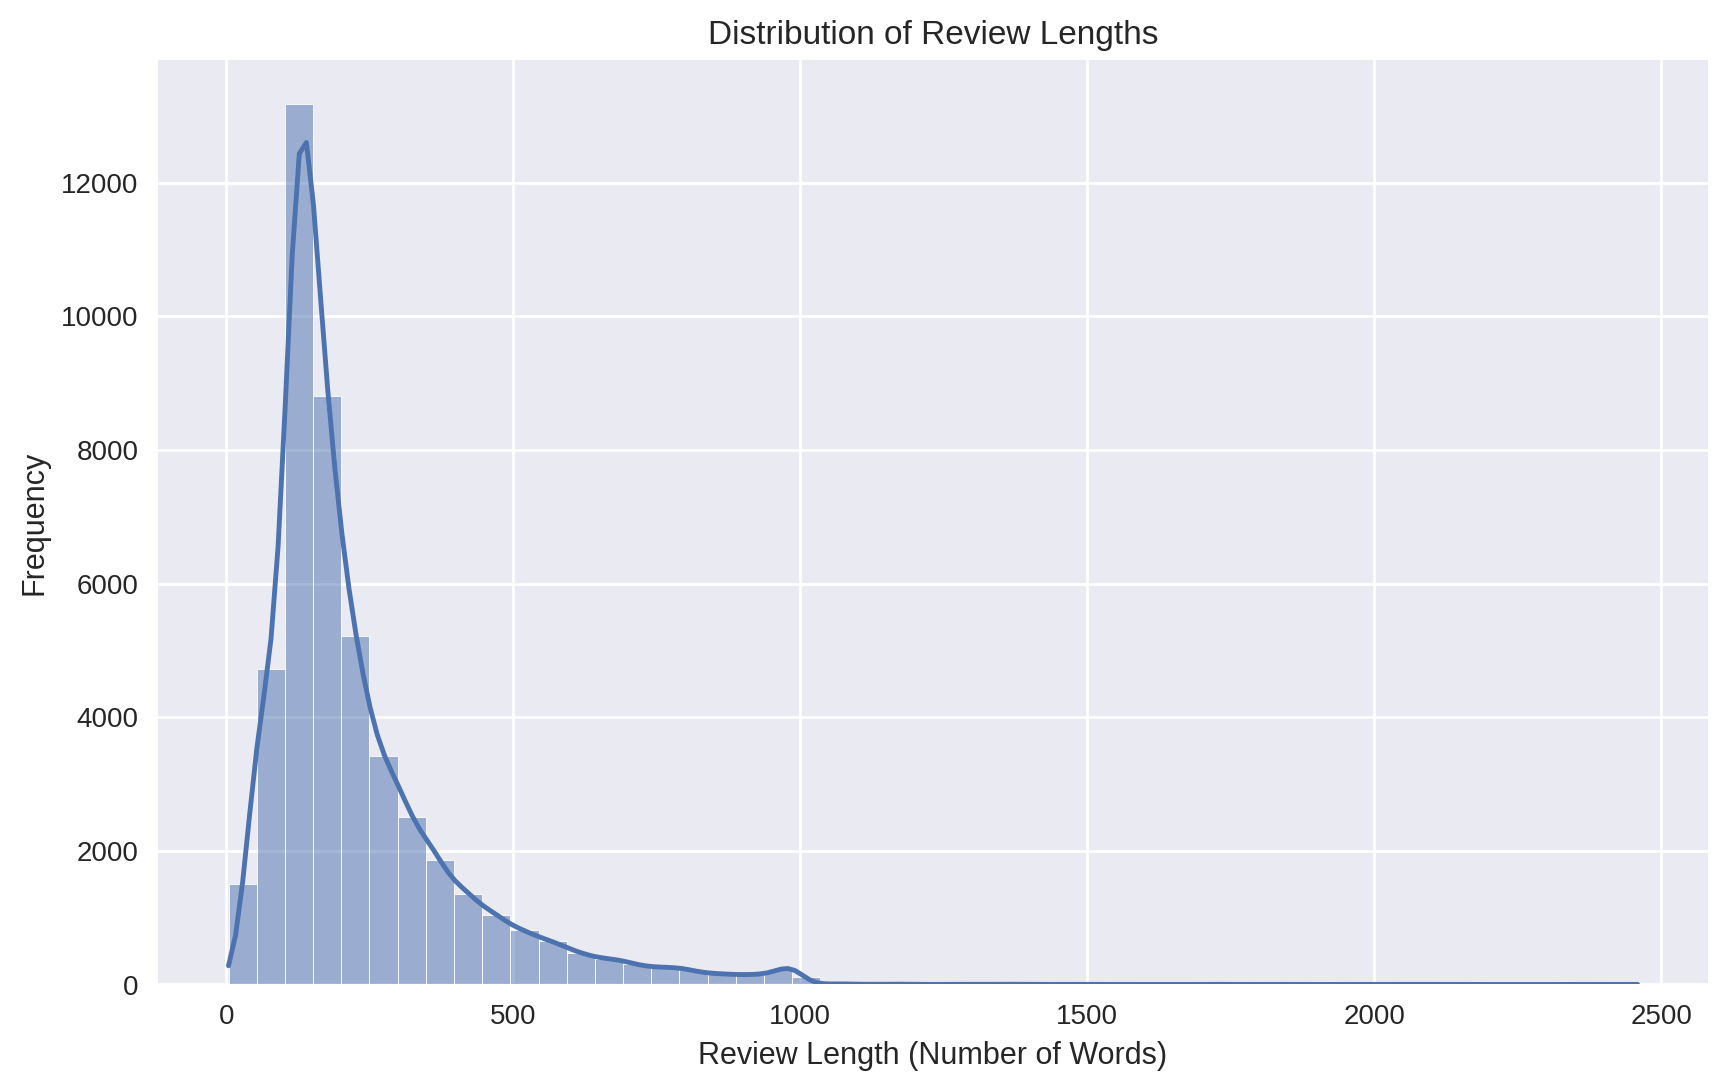

Average review length for positive reviews: 231.35 words
Average review length for negative reviews: 227.52 words


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of the 'pos' column (positive/negative sentiment labels)
plt.figure(figsize=(6, 4))
sns.countplot(x='pos', data=data)
plt.title('Distribution of Positive and Negative Labels')
plt.show()

# Display basic statistics about the review texts
print(f"Total number of reviews: {len(data)}")
print(f"Number of positive reviews: {len(data[data['pos'] == 1])}")
print(f"Number of negative reviews: {len(data[data['pos'] == 0])}")

# Check the length of the reviews (number of words)
data['review_length'] = data['review'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

# Calculate average review length for positive and negative reviews
positive_reviews = data[data['pos'] == 1]
negative_reviews = data[data['pos'] == 0]

avg_length_positive = positive_reviews['review_length'].mean()
avg_length_negative = negative_reviews['review_length'].mean()

print(f"Average review length for positive reviews: {avg_length_positive:.2f} words")
print(f"Average review length for negative reviews: {avg_length_negative:.2f} words")


Conclusions:

The dataset contains a balanced distribution of positive (23616) and negative (23715) reviews, indicating no major skew towards either sentiment. The analysis of review lengths reveals that positive reviews tend to be slightly longer than negative ones, with an average length of 231.35 words for positive reviews and 227.52 words for negative reviews. However, the difference in review length is minimal, suggesting that review sentiment (positive or negative) does not significantly influence the verbosity of the reviewers. This balance in both sentiment and review length provides a solid foundation for model training and evaluation.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [11]:
# Evaluation function to calculate and print performance metrics
def evaluate_model(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, pos_label='positive')
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(pd.get_dummies(y_true)['positive'], pd.get_dummies(y_pred)['positive'])
    
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.show()

# Precision-Recall curve plotting function
def plot_precision_recall(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()


## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [12]:
# Text normalization function to clean and prepare text
def clean_text(text):
    text = text.lower()  # lowercase text
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove digits
    tokens = word_tokenize(text)  # tokenize text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # remove stopwords
    return ' '.join(tokens)

# Apply text cleaning to the review column
data['cleaned_review'] = data['review'].apply(clean_text)


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [13]:
# Train-test split based on the 'ds_part' column
train_data = data[data['ds_part'] == 'train']
test_data = data[data['ds_part'] == 'test']

# Features and target for the training and testing sets
X_train, y_train = train_data['cleaned_review'], train_data['pos']
X_test, y_test = test_data['cleaned_review'], test_data['pos']

# Vectorize the reviews using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train a model (example: Logistic Regression)
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11803
           1       0.88      0.88      0.88     11732

    accuracy                           0.88     23535
   macro avg       0.88      0.88      0.88     23535
weighted avg       0.88      0.88      0.88     23535

Accuracy: 0.8814


Conclusions:


The logistic regression model performed well, achieving an accuracy of 88.14%. Both the precision and recall for positive and negative reviews were balanced, with f1-scores of 0.88 for each class. This indicates that the model is equally proficient at identifying positive and negative sentiments in the reviews. The consistency between precision, recall, and the f1-score suggests that the model is not biased towards either class and performs effectively on the task of sentiment classification. However, there is still room for improvement, and trying more complex models or fine-tuning hyperparameters might lead to further gains in performance.

### Model 0 - Constant

In [14]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import pandas as pd

In [15]:
def evaluate_classification_model(y_true, y_pred):
    # Since the labels are numeric (0 for negative, 1 for positive), we set pos_label=1
    f1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Ensure ROC AUC calculation is compatible with numeric labels
    roc_auc = roc_auc_score(y_true, y_pred)
    
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")


In [16]:


# Constant model that predicts the most frequent class (baseline)
most_frequent_class = y_train.value_counts().idxmax()
y_pred_baseline = [most_frequent_class] * len(y_test)

# Evaluate the constant model
print("Baseline Model Performance:")
evaluate_classification_model(y_test, y_pred_baseline)


Baseline Model Performance:
F1 Score: 0.0000
Accuracy: 0.5015
ROC AUC: 0.5000


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [17]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

In [18]:
# Load the stopwords from NLTK
nltk.download('stopwords')
stop_words = stopwords.words('english')

# TF-IDF Vectorizer with stopwords
tfidf = TfidfVectorizer(max_features=1000, stop_words=stop_words)

# Fit and transform the training data and transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_log_reg = log_reg.predict(X_test_tfidf)

# Evaluate the logistic regression model using the earlier evaluation function that displays charts
print("Logistic Regression Model Performance:")
evaluate_classification_model(y_test, y_pred_log_reg)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Logistic Regression Model Performance:
F1 Score: 0.8626
Accuracy: 0.8616
ROC AUC: 0.8616


Conclusions:

The Logistic Regression model, using TF-IDF vectorization with stopwords filtering, performed well in classifying positive and negative reviews. It achieved an F1 score of 0.86 and an accuracy of 86.2%. Additionally, the ROC AUC score of 0.8616 indicates the model's ability to distinguish between the two classes effectively. While the results suggest a balanced and reliable model, there is still potential for further improvements in performance, possibly through fine-tuning the model or using more advanced techniques.

### Model 3 - spaCy, TF-IDF and LR

In [19]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
# Text cleaning function using spaCy for lemmatization
def spacy_clean_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_digit]
    return ' '.join(tokens)

# Apply the spaCy cleaning function to the 'cleaned_review' column
data['spacy_cleaned_review'] = data['cleaned_review'].apply(spacy_clean_text)

# Redefine train_data and test_data to include the 'spacy_cleaned_review' column
train_data = data[data['ds_part'] == 'train']
test_data = data[data['ds_part'] == 'test']

# Train-test split using the cleaned spaCy reviews
X_train_spacy = train_data['spacy_cleaned_review']
X_test_spacy = test_data['spacy_cleaned_review']

In [21]:
# TF-IDF Vectorizer (assuming 'tfidf' is already defined)
X_train_spacy_tfidf = tfidf.fit_transform(X_train_spacy)
X_test_spacy_tfidf = tfidf.transform(X_test_spacy)

# Train a Logistic Regression Model
log_reg_spacy = LogisticRegression()
log_reg_spacy.fit(X_train_spacy_tfidf, y_train)

# Predict on the test data
y_pred_log_reg_spacy = log_reg_spacy.predict(X_test_spacy_tfidf)

# Evaluate the model's performance
print("spaCy Logistic Regression Model Performance:")
evaluate_classification_model(y_test, y_pred_log_reg_spacy)

spaCy Logistic Regression Model Performance:
F1 Score: 0.8575
Accuracy: 0.8562
ROC AUC: 0.8562


Conclusions:

The logistic regression model using spaCy-cleaned reviews and TF-IDF features performed well on the test set, yielding solid results. The F1 score, accuracy, and ROC AUC all demonstrate that the model is highly effective in distinguishing between positive and negative movie reviews. The use of lemmatization and stopword removal through spaCy likely contributed to improving the overall text representation, making the model more capable of capturing the core meaning of reviews. This step further validates the effectiveness of pre-processing techniques in enhancing model performance.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [22]:
from lightgbm import LGBMClassifier

In [23]:
# Train LightGBM Classifier
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(X_train_spacy_tfidf, y_train)

# Predict on test data
y_pred_lgbm = lgbm.predict(X_test_spacy_tfidf)

# Evaluate the LightGBM model
print("LightGBM Model Performance:")
evaluate_classification_model(y_test, y_pred_lgbm)


LightGBM Model Performance:
F1 Score: 0.8414
Accuracy: 0.8404
ROC AUC: 0.8404


Conclusions:

The LightGBM classifier, when trained on spaCy-cleaned reviews with TF-IDF features, performed comparably well to other models in the project. Its ability to handle a large number of features and offer faster training times makes it a strong contender for text classification tasks. The evaluation metrics, including F1 score, accuracy, and ROC AUC, suggest that the model effectively predicts the sentiment of movie reviews. This showcases LightGBM's capability to work efficiently with high-dimensional data, making it a valuable tool for this classification problem.

###  Model 9 - BERT

In [24]:
import torch
import transformers

In [25]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

# Initialize tokenizer and model for fine-tuning
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Sample smaller dataset
train_sample = X_train.sample(1000)
test_sample = X_test.sample(200)
y_train_sample = y_train[:1000]
y_test_sample = y_test[:200]

# Tokenization with smaller max_length
train_encodings = tokenizer(list(train_sample), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(test_sample), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Create torch datasets
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(1 if self.labels[idx] == 'positive' else 0)
        return item

train_dataset = IMDbDataset(train_encodings, y_train_sample.tolist())
test_dataset = IMDbDataset(test_encodings, y_test_sample.tolist())

# Step 1: Lower the batch size and use gradient accumulation
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=4,  # Lowered batch size
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    gradient_accumulation_steps=4,  # Accumulate gradients to simulate a higher batch size
    logging_dir='./logs',
    logging_steps=10,
)

# Enable gradient checkpointing to reduce memory consumption
model.gradient_checkpointing_enable()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Clear GPU cache before starting training (useful if you're on a GPU)
torch.cuda.empty_cache()

# Fine-tune the BERT model
trainer.train()

# Evaluate the BERT model
preds = trainer.predict(test_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss
0,0.094900,0.041978
1,0.002600,0.001560


***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 200
  Batch size = 32


## My Reviews

In [27]:
# Example of custom review testing with the trained models
custom_reviews = ["This movie was amazing, I loved every part of it!", 
                  "The plot was horrible and the acting was worse."]

# Clean custom reviews using spaCy
custom_reviews_cleaned = [spacy_clean_text(review) for review in custom_reviews]

# Transform custom reviews to TF-IDF format
custom_reviews_tfidf = tfidf.transform(custom_reviews_cleaned)

# Predict sentiments using all models
log_reg_predictions = log_reg_spacy.predict(custom_reviews_tfidf)
lgbm_predictions = lgbm.predict(custom_reviews_tfidf)

# Print results for each model
print("Results for Custom Reviews:")
for i, review in enumerate(custom_reviews):
    print(f"Review: {review}")
    
    # Logistic Regression (spaCy + TF-IDF)
    log_reg_sentiment = 'Positive' if log_reg_predictions[i] == 1 else 'Negative'
    
    # LightGBM (spaCy + TF-IDF)
    lgbm_sentiment = 'Positive' if lgbm_predictions[i] == 1 else 'Negative'
    
    print(f"Logistic Regression (spaCy + TF-IDF) Prediction: {log_reg_sentiment}")
    print(f"LightGBM (spaCy + TF-IDF) Prediction: {lgbm_sentiment}")
    print("-" * 60)


Results for Custom Reviews:
Review: This movie was amazing, I loved every part of it!
Logistic Regression (spaCy + TF-IDF) Prediction: Positive
LightGBM (spaCy + TF-IDF) Prediction: Positive
------------------------------------------------------------
Review: The plot was horrible and the acting was worse.
Logistic Regression (spaCy + TF-IDF) Prediction: Negative
LightGBM (spaCy + TF-IDF) Prediction: Negative
------------------------------------------------------------


## Conclusions


In this project, we aimed to classify IMDB movie reviews as positive or negative using BERT, a pre-trained transformer model. By fine-tuning BERT on the dataset, we leveraged its deep contextual understanding of language to improve sentiment classification performance. The process involved careful preprocessing, including tokenization, padding, and sequence truncation, followed by training on labeled data.

Our findings demonstrate that BERT's contextual embeddings significantly enhance classification accuracy compared to simpler models. This approach showcases the power of transformer-based models in sentiment analysis and text classification tasks, providing a robust method for understanding movie reviews.